# The DeepONet method in JAX

# How the DeepONet works for one output query point:

Before we get into the code, let's talk about the DeepONet math in order to design an algorithm that makes the implentation in JAX vectorized, fast and  memory efficient.

Let's consider the case of a DeepONet as shown below:

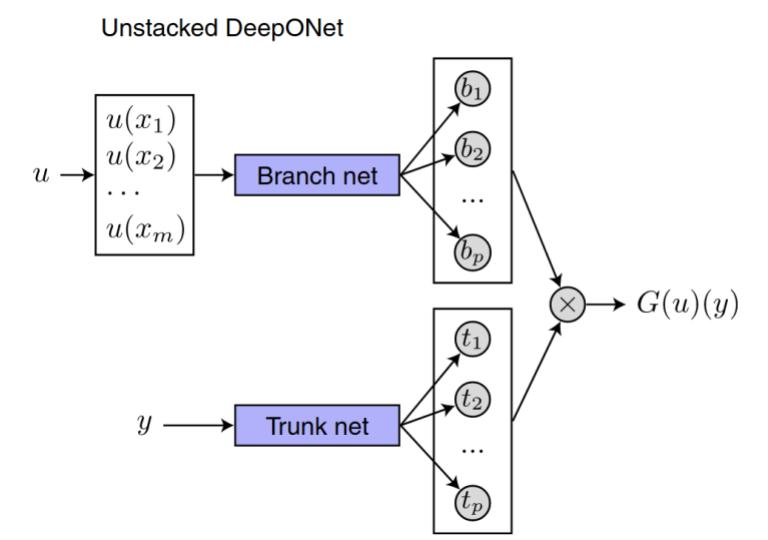

Given $\mathcal{X} ⊂ \mathbb{R}^{d_x}$, $\mathcal{Y} ⊂ \mathbb{R}^{d_y}$ we refer to $x \in \mathcal{X}$ as the input and  $y \in \mathcal{Y}$ as the query locations. We define functions $u^l \in \mathcal{C}(\mathcal{X}, \mathbb{R}^{d_u})$ the input functions and $s^l \in \mathcal{C}(\mathcal{Y}, \mathbb{R}^{d_s})$ the output functions. 

Our goal is to learn an operator $\mathcal{G}: \mathcal{C}(\mathcal{X}, \mathbb{R}^{d_u}) \to \mathcal{C}(\mathcal{Y}, \mathbb{R}^{d_s})$ using pairs of input/output functions $\{ u^l(x), s^l(y) \}_{l=1}^N$. 

To do that we consider the parameterized model:

$$\mathcal{F}(u)(y) = \sum_{i=1}^n t(y)_i b(u)_i,   \quad \quad (1)$$

where $b$ and $t$ the branch and the trunk networks, respectively. 

Therefore, the branch network is a function $b: \mathbb{R}^{m \times d_u} \to \mathbb{R}^{n \times d_s}$ of the input $u$ and the trunk net is a function $t: \mathbb{R}^{1 \times d_y} \to \mathbb{R}^{n \times d_s}$ of the query location $y^i_l$. For each input and query location (1) provides an output $s^i_l \in \mathbb{R}^{1 \times ds}$. 

Now that we wrote (1) for one query point we can use the JAX library automatic vectorization properties to vectorize (1) over multiple query points and multiple dimensions. 

Read 3.1.7 for more information
- [A comprehensive and fair comparison of two neural operators
(with practical extensions) based on FAIR data](https://arxiv.org/pdf/2111.05512.pdf)

# Predicting flow through a porous medium

Fluid flow through porous media is governed by Darcy's Law, which can be mathematically expressed by the following partial differential equation system,
$$ \nabla \cdot ( u(x) \nabla s(x)) = f(x), \quad x \in \mathcal{X},$$
subject to appropriate boundary conditions

$$ s = 0   \quad \text{on} \quad \Gamma_\mathcal{X},$$ 
$$(u(x)  \nabla  s(x)) \cdot n = g  \quad \text{ on } \Gamma_N, $$
where $u$ is permeability of the porous medium, and $s$ is the corresponding fluid pressure. Here we consider a domain $\mathcal{X} = [0,1] \times [0,1]$ with a Dirichlet boundary  $\Gamma_D = \{ (0,x) \cup (1,x)\;|\;x_2 \in [0,1] \subset \partial \mathcal{X} \}$, and a Neumann boundary $\Gamma_N = \{ (x,0) \cup (x,1) \;|\;x \in [0,1]\subset \partial \mathcal{X} \}$. 

For a given forcing term $f$ and set of boundary conditions, the solution operator $\mathcal{G}$ of system maps the permeability function $u(x)$ to the fluid pressure function $s(x)$. In the notation of our model, the input and output function domains coincide, $\mathcal{X} = \mathcal{X}$ with $d_x = d_y = 2$. Since in this case the solution operator is a map between scalar functions, we also have $d_u = d_s = 1$. Under this setup, our goal is to learn the solution operator $\mathcal{G}: C(\mathcal{X}, \mathbb{R}) \to C(\mathcal{X}, \mathbb{R})$. 

We set the Neumann boundary condition to be $g(x) = \sin(5x)$, the forcing term $f(x) = 5 \exp( - ((x_1-0.5)^2 + (x_2-0.5)^2))$, and sample the permeability function $u(x)$ from a Gaussian measure, as $u(x) = \exp(u_0 \cos(x))$ with $u_0 \sim \mathcal{N}(0, 7^{3/2}(- \Delta + 49 I)^{-1.5}$. The training and testing data sets are constructed by sampling the initial condition along a $N_x \times N_y$ grid and solving the forward problem with the Finite Element library, Fenics. This gives us access to $N_x \times N_y$ solution values to use for training different operator learning models.

# An introduction to stax

Stax is a JAX library that instead of using objects as the data structures for neural networks, it uses pure functions. In this case, the model parameters are not attributes of some Python class used to define our model, but objects that we need to handle explicitly.

For this purpose, all the layers of stax are defined by a forward pass, that applied a mathematical transformation, and an initialization function, that initializes the parameters of the model into the correct shape. Because the stax layers are pure functions we need to explicitly provide the model parameters at each forward pass after we recover them from the state of the optimizer. 

The cool thing about stax is allows to define and stack layers in serial and parallel and, in this case, that provides automatic vectorization of the forward pass by just providing the correct arguments to the initialization parameter shapes. 

For more information, see:

- [Linear models with Stax](https://ericmjl.github.io/dl-workshop/03-stax/01-linear.html)
- [Neural networks with stax](https://ericmjl.github.io/dl-workshop/03-stax/02-neural.html)

# Handling States

In a previous section, we described how JAX only considers pure functions (side effect free) for its computations. This rises the question of how JAX can handle program states that are common in Machine Learning, like:

* model parameters,
* optimizer state.

For example, updating optimizer parameters is equivalent to changing the state of the model which is a side-effect. So, if we can't have side effects, how do we update model parameters, the optimizer state, and use stateful layers in our models? 

Moreover, function transformation like jit impose the constraint that the compiled function must have no side-effects, because they cannot be traced, and they will only be executed once. 

We solve the above discrepancy by considering some tricks from [functional programming](https://en.wikipedia.org/wiki/Functional_programming).

References:
[JAX Documentation](https://jax.readthedocs.io/en/latest/index.html)

Let's start by looking at a simple program which preserves its state:



In [ ]:
import jax 
class Counter:
  def __init__(self):
    self.state = 0

  def count(self) -> int:
    self.state += 1
    return self.state

counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


The `state` attribute contains the state of the counter and it is updated by consequtive calls of the function `count`.

Let's apply `jax.jit` to this function to see what happens:

In [ ]:
counter = Counter()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


This is not working because 
```
self.n += 1
```
is only called once, when JAX compiles the method call. Remember that side-effects are not translated to jaxpr and the ouput statements of the jaxpr functions should depend on their input arguments. For these two reasons the `fast_count` function will always return 1.


We can solve both of the above problems at once if we consider the state of the counter as an input to the counting function:

In [ ]:
from typing import Tuple

CounterState = int

class CounterV2: #(doesn't even need to be a class)
  def count(self, state: CounterState) -> Tuple[int, CounterState]:
    #The outputs are the same, but we separate them for clarity.
    return state+1, state+1

state = 0
counter = CounterV2()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


In this version of the counter, the state is an explicit argument of the count function. Now the count function returns the new value and the new state of the system, which can then be used as an argument for subsequent calls:

In [ ]:
state = 0
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


# Importing the necessary libraries for implementing the DeepONet method:

Let's first import the libraries that we are going to use for implementing the DeepONet method:

In [ ]:
from absl import app
import numpy as np
from functools import partial 
import timeit
import itertools
from torch.utils import data
from tqdm import trange
import os


import jax
import jax.numpy as jnp
from jax import vjp
from jax.experimental import optimizers
from jax.experimental.stax import Dense, Gelu, serial
from jax.numpy.linalg import norm
from jax import random, grad, jit
from jax.flatten_util import ravel_pytree

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"



/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Randomly choosing output labels for training

In contrast to the Image2image regression, where for each of the N input/output function pairs, $(u_i, s_i)$ we need the full resolution of the output as labels, in DeepONet we can randomly subsample the output function queries to use as labels for our input data. We will consider $m$ discrete measurements of each input function at fixed locations, $(u^i(x^i_1), . . . , u^i(x^i_m))$, and $M$ available discrete measurements of each output function $(s^i(y^i_1), . . . , si(y^i_M ))$, with the query locations $ \{ y^i_l \}^M_{l=1}$ potentially varying over the data set. Out of the $M$ available measurement points $\{ y^i_l \}^M_{l=1}$ for each output function $s^i$, we consider the effect of taking only $P$ of these points for each input/output pair. 


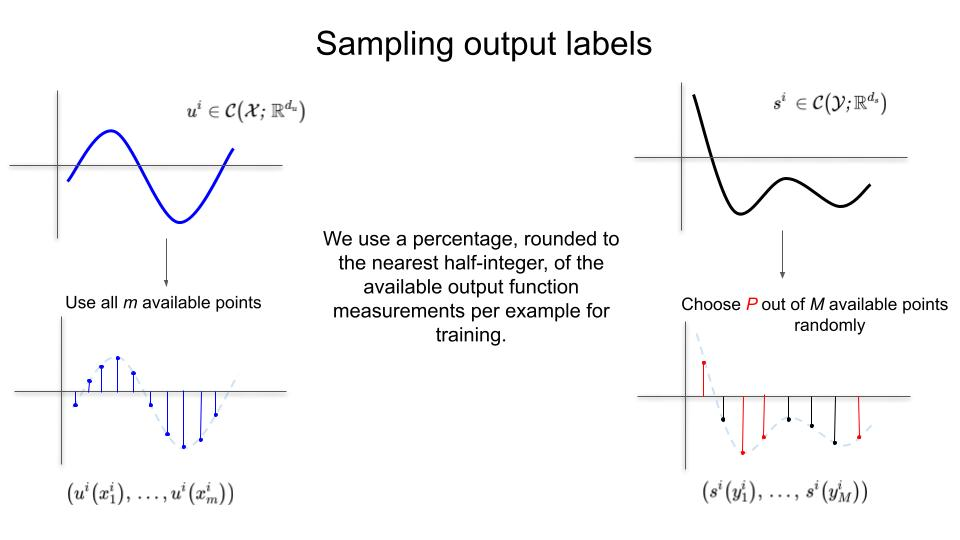


The DeepONet implementation we provide assumes a fixed number of output measurements $P$, which is not as general.


For sampling the $P$ labels from the output domain we employ the function:

In [ ]:
def output_construction(s,Y,P=100,ds=1, dy=2, N=1000,Nx=100,Ny=100):
    s = s.reshape(Nx,Ny, ds)
    Y = Y.reshape(Nx,Ny, dy)
    x = np.random.randint(Nx, size=P)
    y = np.random.randint(Ny, size=P)
    Y_all = Y[x][range(P), y, :]
    s_all = s[x][range(P), y, :]
    return s_all, Y_all

# Handling batches 

For fetching mini-batches during training, we will define a `DataGenerator` class, which performs two actions:

* Creates a random key each time that it is called,
* Randomly chooses batches of realizations from the data-set and returns a tuple containing the argumetns of the forward pass $\mathcal{F}(u^i)(y^i)$ and $s^i$ target functions for comparing with the prediction in the loss function. 

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s,
                 batch_size=100, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs,outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:,:]
        u  = self.u[idx,:,:]
        y = self.y[idx,:,:]
        inputs = (u, y)
        return inputs, s

# Harmonic feature expansion

Lu _et. al._ proposed in their paper _"A comprehensive and fair comparison of two neural operators (with practical extensions) based on fair data."_ a technique called Harmonic Feature Expansion defined as:

$$(cos(2^0 \pi y), sin(2^0 \pi y), cos(2^1 \pi y), sin(2^1 \pi y),..., cos(2^H \pi y),sin(2^H \pi y))$$

which is then concatenated to the query locations. We perform the same augmentation with the input function samples. This process is performed for each dimension separately: 
$$e(y^i, 2j + (i-1)H  = cos(2^i \pi y^i) \\ 
e(y^i, 2j + 1+ (i-1)H = sin(2^i \pi y^i) $$

where $H$ the number of expansion coefficients, $j = 1,...,H/2$, $y^i$ the query coordinates in different spatial dimensions and $i = 1,...,d_y$. 

For this purpose, we create a vectorized function in JAX to apply the above efficiently to the whole dataset. 

The Harmonic Feature Expansion or other types of encodings, i.e. positional encodings in the Transformers literature, provide an intuitive way to include indirect positional information about the functions that are feeded to a neural network. This has been proven to be very effective in the Transformers literature and it is widely used. 

In learning for physics, positional encodings provide an intuitive way to handle different structures that might be present in a dataset that comes from some physical system, like periodic boundary conditions, oscillations, high frequencies, all at once. 

In [ ]:
class HarmonicFeatureExpansionY:
    def __init__(self, Y, d_model, max_len = 100, H=20):
        self.d_model = int(np.ceil(d_model/4)*2)
        self.Y = Y
        self.max_len = max_len
        self.H = H

    @partial(jit, static_argnums=(0,))
    def forward(self, x):
        pex = np.zeros((x.shape[0], self.max_len, self.H))
        pey = np.zeros((x.shape[0], self.max_len, self.H))
        T = jnp.take(self.Y, 0, axis=2)[:,:,None]
        X = jnp.take(self.Y, 1, axis=2)[:,:,None]
        positionT = jnp.tile(T,(1,1,self.H))
        positionX = jnp.tile(X,(1,1,self.H))
        div_term = 2**jnp.arange(0,int(self.H/2),1)*jnp.pi
        pex = jax.ops.index_update(pex, jax.ops.index[:,:,0::2], jnp.cos(positionT[:,:,0::2] * div_term))
        pex = jax.ops.index_update(pex, jax.ops.index[:,:,1::2], jnp.sin(positionT[:,:,1::2] * div_term))
        pey = jax.ops.index_update(pey, jax.ops.index[:,:,0::2], jnp.cos(positionX[:,:,0::2] * div_term))
        pey = jax.ops.index_update(pey, jax.ops.index[:,:,1::2], jnp.sin(positionX[:,:,1::2] * div_term))
        pos_embedding =  jnp.concatenate((pex,pey),axis=-1)
        x =  jnp.concatenate([x, pos_embedding], -1)
        return x

class HarmonicFeatureExpansionU:
    def __init__(self, U, d_model, max_len = 100, H=20):
        self.d_model = int(np.ceil(d_model/2)*2)
        self.U = U
        self.max_len = max_len
        self.H = H

    @partial(jit, static_argnums=(0,))
    def forward(self, x):
        peu = np.zeros((x.shape[0], self.max_len, self.H))
        U = jnp.take(self.U, 0, axis=2)[:,:,None]
        positionU = jnp.tile(U,(1,1,self.H))
        div_term = 2**jnp.arange(0,int(self.H/2),1)*jnp.pi
        peu = jax.ops.index_update(peu, jax.ops.index[:,:,0::2], jnp.cos(positionU[:,:,0::2] * div_term))
        peu = jax.ops.index_update(peu, jax.ops.index[:,:,1::2], jnp.sin(positionU[:,:,1::2] * div_term))
        x =  jnp.concatenate([x, peu], -1)
        return x

# Loss Function

For training the model, we consider a relative $\mathcal{L}_2$ error loss: 
$$ \mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^P \frac{\| s^i(y_j^i) - \mathcal{G}(u^i)(y_j^i) \|^2_2}{\| s^i(y_j^i) \|^2_2}$$

as in the Fourier Neural Operators, which we will see in the next tutorial. The $\mathcal{L}_2$ loss function weights each component differently depending on the norm of the target function sample. 


One of the reason we employ this loss function is to to avoid biasing the model towards over-fitting to functions with larger magnitudes. Moreover, there has been a success of methods that consider adaptive weights to the loss function and this is a intuitive way to choose the weights.

In [ ]:
class LpLoss(object):
    def __init__(self, d=2, p=2):
        super(LpLoss, self).__init__()
        self.d = d
        self.p = p

    def rel(self, x, y):
        num_examples = x.shape[0]
        diff_norms = jnp.linalg.norm(y.reshape(num_examples,-1) - x.reshape(num_examples,-1), self.p, 1)
        y_norms = jnp.linalg.norm(y.reshape(num_examples,-1), self.p, 1)
        return jnp.mean(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

# DeepONet model implementation

At this point we will define a class which we will call DON and will contain the DeepONet model definition, forward pass, the optimizer and the training loop. 

We will explain the important parts of this class:

Following the `stax` library syntax we define two pure function, one for the branch and one for the trunk network using the network initialization funtion `init_NN` which returns one apply and one initialization function. We define the input shapes as `(-1, branch_layers[0])` and `(-1, trunk_layers[0])` to indicate that we want the function to be vectorized in every dimension except for the last.

```
self.branch_init, self.branch_apply = self.init_NN(branch_layers, activation=Gelu)
        self.in_shape = (-1, branch_layers[0])
        self.out_shape, branch_params = self.branch_init(random.PRNGKey(10000), self.in_shape)

self.trunk_init, self.trunk_apply = self.init_NN(trunk_layers, activation=Gelu)
        self.in_shape = (-1, trunk_layers[0])
        self.out_shape, trunk_params = self.trunk_init(random.PRNGKey(10000), self.in_shape)

```

We talked in the previous tutorial about handling states in JAX. Considering that we are working with pure functions, we need in the function definitions to get the state of the function explicitly as well as a function to update the state of the optimizer and a function to access the parameters of the model.


```
self.opt_init,self.opt_update,self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=100, 
                                                                      decay_rate=0.99))

```

We discussed on the start of the tutorial how the DeepONet method works for one query coordinate $y^i_l$. The forward pass presented below follows is exactly this process vectorized to handled $P$ points at the same time. 

```
def DON(self, params, inputs, ds=1, n=100):
      trunk_params, branch_params = params
      inputsxu, inputsy = inputs
      t = self.trunk_apply(trunk_params, inputsy).reshape(inputsy.shape[0], inputsy.shape[1], ds, int(n/ds))
      b = self.branch_apply(branch_params, inputsxu.reshape(inputsxu.shape[0],1,inputsxu.shape[1]*inputsxu.shape[2]))
      b = b.reshape(b.shape[0],int(b.shape[2]/ds),ds)
      Guy = jnp.einsum("ijkl,ilk->ijk", t,b)
      return Guy
```

In order to count the model parameters, we use the following three functions, which essentially flatten the list of lists (PyTree) that contains the parameters and then counts its elements. 

```
    def count_params(self, params):
        trunk_params, branch_params = params
        blv, _ = ravel_pytree(branch_params)
        tlv, _ = ravel_pytree(trunk_params)
        print("The number of model parameters is:",blv.shape[0]+tlv.shape[0])
```

The way the other functions work is self explanatory, therefore we will not go into details.

The whole `DeepONet` model class is presented below:

In [ ]:
class DON:
    def __init__(self,branch_layers, trunk_layers , m=100, P=100, mn=None, std=None):    
        # Network initialization and evaluation functions

        self.branch_init, self.branch_apply = self.init_NN(branch_layers, activation=Gelu)
        self.in_shape = (-1, branch_layers[0])
        self.out_shape, branch_params = self.branch_init(random.PRNGKey(10000), self.in_shape)

        self.trunk_init, self.trunk_apply = self.init_NN(trunk_layers, activation=Gelu)
        self.in_shape = (-1, trunk_layers[0])
        self.out_shape, trunk_params = self.trunk_init(random.PRNGKey(10000), self.in_shape)

        self.L2loss = LpLoss()

        params = (trunk_params, branch_params)
        
        # Use optimizers to set optimizer initialization and update functions
        self.opt_init,self.opt_update,self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=100, 
                                                                      decay_rate=0.99))
        self.opt_state = self.opt_init(params)
        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

        self.mean = mn
        self.std = std

    def init_NN(self, Q, activation=Gelu):
        layers = []
        num_layers = len(Q)
        if num_layers < 2:
            net_init, net_apply = serial()
        else:
            for i in range(0, num_layers-1):
                layers.append(Dense(Q[i+1]))
                layers.append(activation)
            layers.append(Dense(Q[-1]))
            net_init, net_apply = serial(*layers)
        return net_init, net_apply

    @partial(jax.jit, static_argnums=0)
    def DON(self, params, inputs, ds=1, n=100):
        trunk_params, branch_params = params
        inputsxu, inputsy = inputs
        t = self.trunk_apply(trunk_params, inputsy).reshape(inputsy.shape[0], inputsy.shape[1], ds, int(n/ds))
        b = self.branch_apply(branch_params, inputsxu.reshape(inputsxu.shape[0],1,inputsxu.shape[1]*inputsxu.shape[2]))
        b = b.reshape(b.shape[0],int(b.shape[2]/ds),ds)
        Guy = jnp.einsum("ijkl,ilk->ijk", t,b)
        return Guy
      
    @partial(jax.jit, static_argnums=0)
    def loss(self, params, batch):
        inputs, y = batch
        y_pred = self.DON(params,inputs)
        y = y*self.std + self.mean
        y_pred = y_pred*self.std + self.mean
        loss = self.L2loss(y_pred, y)
        return loss    

    @partial(jax.jit, static_argnums=0)
    def lossT(self, params, batch):
        inputs, y = batch
        y_pred = self.DON(params,inputs)
        y_pred = y_pred*self.std + self.mean
        loss = self.L2loss(y_pred, y)
        return loss    

    @partial(jax.jit, static_argnums=0)
    def L2errorT(self, params, batch):
        inputs, y = batch
        y_pred = self.DON(params,inputs)
        y_pred = y_pred*self.std + self.mean
        return norm(y.flatten() - y_pred.flatten(), 2)/norm(y.flatten(),2)

    @partial(jax.jit, static_argnums=0)
    def L2error(self, params, batch):
        inputs, y = batch
        y_pred = self.DON(params,inputs)
        y = y*self.std + self.mean
        y_pred = y_pred*self.std + self.mean
        return norm(y.flatten() - y_pred.flatten(), 2)/norm(y.flatten(),2)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    def train(self, train_dataset, test_dataset, nIter = 10000):
        train_data = iter(train_dataset)
        test_data  = iter(test_dataset)

        pbar = trange(nIter)
        for it in pbar:
            train_batch = next(train_data)
            test_batch  = next(test_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, train_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss_train = self.loss(params, train_batch)
                loss_test  = self.lossT(params, test_batch)
                errorTrain = self.L2error(params, train_batch)
                errorTest  = self.L2errorT(params, test_batch)
                self.loss_log.append(loss_train)
                pbar.set_postfix({'Training loss': loss_train, 
                                  'Testing loss' : loss_test,
                                  'Test error':    errorTest,
                                  'Train error':   errorTrain})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        s_pred = self.DON(params,inputs)
        return s_pred*self.std + self.mean

    @partial(jit, static_argnums=(0,))
    def predictT(self, params, inputs):
        s_pred = self.DON(params,inputs)
        return s_pred*self.std + self.mean
        
    def count_params(self):
        params = self.get_params(self.opt_state)
        params_flat, _ = ravel_pytree(params)
        print("The number of model parameters is:",params_flat.shape[0])

# Helper functions for prediction and error computation

We employ two helper functions, one for making predictions for the full resolution of the dataset and one for computing the error between the target and the predicted full resolution solution. 

In the predict function, we need to apply the harmonic feature expansion to the whole spatial grid for all realizations. This is handled by the `HarmonicFeatureExpansion` class presented previously. The input function samples are re-used.

In [ ]:
def predict_function(U_in,Y_in, model=None, params= None, H=10):
    y = np.expand_dims(Y_in,axis=0)
    y = np.tile(y,(U_in.shape[0],1,1))
    inputs_trainxu = jnp.asarray(U_in)
    pos_encodingy  = HarmonicFeatureExpansionY(y,int(y.shape[1]*y.shape[2]), max_len = Y_in.shape[0], H=H)
    y  = pos_encodingy.forward(y)
    del pos_encodingy
    uCNN_super_all = model.predict(params, (inputs_trainxu, y))
    return uCNN_super_all

def error_full_resolution(uCNN_super_all, s_all,tag='train', num_train=1000, Nx=32, Ny=32):
    test_error_u = []
    z = uCNN_super_all.reshape(num_train,Nx,Ny)
    s = s_all.reshape(num_train,Nx,Ny)
    for i in range(0,num_train):
        test_error_u.append(norm(s[i,:,:]- z[i,:,:], 2)/norm(s[i,:,:], 2))
    print("The average "+tag+" u error for the super resolution is %e, the standard deviation %e, the minimum error is %e and the maximum error is %e"%(np.mean(test_error_u),np.std(test_error_u),np.min(test_error_u),np.max(test_error_u)))

# Main part of the model

## Importing the training and testing datasets

We present the main part of the function that implements the DeepONet architecture. 

First we load the data and randomly choose output labels:

In [ ]:
TRAINING_ITERATIONS = 10000
num_train = 5000
num_test  = 5000
howmany = num_train//5
training_batch_size = 100
du = 1
dy = 2
ds = 1
n_hat  = 100
H_y = 2
H_u = 2

sub = 8
s = 256
h = s//sub
Nx = h
Ny = h
m = h*h
P = 128

d = np.load("/content/drive/MyDrive/Tripods_Winter_School_2022/train_darcy_dataset.npz")
U_train   = d["U_train"].reshape(num_train,s,s)[:howmany,::sub,::sub].reshape(howmany,h*h)
Y_train   = d["Y_train"].reshape(s,s, dy)[::sub,::sub, :].reshape(h*h,dy)
S_train   = d["s_train"].reshape(num_train,s,s)[:howmany,::sub,::sub]

d = np.load("/content/drive/MyDrive/Tripods_Winter_School_2022/test_darcy_dataset.npz")
U_test   = d["U_test"].reshape(num_test,s,s)[:howmany,::sub,::sub].reshape(howmany,h*h)
Y_test   = d["Y_test"].reshape(s,s, dy)[::sub,::sub, :].reshape(h*h,dy)
S_test   = d["s_test"].reshape(num_test,s,s)[:howmany,::sub,::sub]

s_train = np.zeros((howmany,P,ds))
y_train = np.zeros((howmany,P,dy))

s_test = np.zeros((howmany,P,ds))
y_test = np.zeros((howmany,P,dy))

for i in range(0,howmany):
    s_train[i,:,:], y_train[i,:,:] = output_construction(S_train[i,:], Y_train, Nx=Nx, Ny=Ny, P=P, ds=ds)

for i in range(0,howmany):
    s_test[i,:,:], y_test[i,:,:]   = output_construction(S_test[i,:], Y_test, Nx=Nx, Ny=Ny, P=P, ds=ds)

## Transforming them to JAX arrays

Then we transform the NumPy arrays into JAX DeviceArrays:

In [ ]:
U_train = jnp.asarray(U_train).reshape(howmany, m, du)
y_train = jnp.asarray(y_train)
s_train = jnp.asarray(s_train)

U_test = jnp.asarray(U_test).reshape(howmany, m, du)
y_test = jnp.asarray(y_test)
s_test = jnp.asarray(s_test)


U_test = jnp.exp(U_test*jnp.cos(jnp.tile(jnp.linspace(0,1,h),(h))[None,:, None]))
U_train = jnp.exp(U_train*jnp.cos(jnp.tile(jnp.linspace(0,1,h),(h))[None,:, None]))


U_train = jnp.reshape(U_train,(howmany,m,du))
y_train = jnp.reshape(y_train,(howmany,P,dy))
s_train = jnp.reshape(s_train,(howmany,P,ds))

U_test = jnp.reshape(U_test,(howmany,m,du))
y_test = jnp.reshape(y_test,(howmany,P,dy))
s_test = jnp.reshape(s_test,(howmany,P,ds))

## Applying the Harmonic Feature Expansion

Apply the Harmonic Feature Expansion to both the output query points and the input function samples:

In [ ]:
pos_encodingy  = HarmonicFeatureExpansionY(y_train,int(y_train.shape[1]*y_train.shape[2]), max_len = P, H=H_y)
y_train  = pos_encodingy.forward(y_train)
del pos_encodingy

pos_encodingyt = HarmonicFeatureExpansionY(y_test,int(y_test.shape[1]*y_test.shape[2]), max_len = P, H=H_y)
y_test   = pos_encodingyt.forward(y_test)
del pos_encodingyt

pos_encodingy  = HarmonicFeatureExpansionU(U_train,int(U_train.shape[1]*U_train.shape[2]), max_len = m, H=H_u)
U_train  = pos_encodingy.forward(U_train)
del pos_encodingy

pos_encodingyt = HarmonicFeatureExpansionU(U_test,int(U_test.shape[1]*U_test.shape[2]), max_len = m, H=H_u)
U_test   = pos_encodingyt.forward(U_test)
del pos_encodingyt

## Normalizing the output labels

Normalize the output labels to have zero mean and unit variance (use this option if your loss is not the relative $\mathcal{L}_2$:

In [ ]:
Normalization = False
if Normalization:
    s_train_mean = jnp.mean(s_train,axis=0)
    s_train_std  = jnp.std(s_train,axis=0)

s_train_mean = 0.
s_train_std  = 1.

s_train = (s_train - s_train_mean)/s_train_std

## Handling mini-batches

Pass the train and testing dataset to the DataGenerator class for creating mini-batches during training:

In [ ]:
train_dataset = DataGenerator(U_train, y_train, s_train, training_batch_size)
train_dataset = iter(train_dataset)

test_dataset = DataGenerator(U_test, y_test, s_test, training_batch_size)
test_dataset = iter(test_dataset)

## Choosing the model architecture

Define the network architecture and the model class:

In [ ]:
branch_layers = [m*(du*H_u+du), 100, 100, 100, 100, 100, 100, ds*n_hat]
trunk_layers  = [H_y*(dy + 1) , 100, 100, 100, 100, 100, 100, ds*n_hat]

model = DON(branch_layers, trunk_layers, m=m, P=P, mn=s_train_mean,  std=s_train_std)

model.count_params()

The number of model parameters is: 449400


## Training the model

Train the model and compute the wall-clock time needed for training:

In [ ]:
start_time = timeit.default_timer()
model.train(train_dataset, test_dataset, nIter=TRAINING_ITERATIONS)
elapsed = timeit.default_timer() - start_time
print("The training wall-clock time is seconds is equal to %f seconds"%elapsed)

100%|██████████| 10000/10000 [01:09<00:00, 142.94it/s, Training loss=0.005918517, Testing loss=0.010106159, Test error=0.010627324, Train error=0.0060594706]

The training wall-clock time is seconds is equal to 69.971931 seconds


## Making predictions and computing the error

Use the model parameters to make predictions:

In [ ]:
opt_params = model.get_params(model.opt_state)

print("Predicting the solution for the full resolution")
uCNN_super_all_test = np.zeros_like(S_test).reshape(howmany, Nx*Ny, ds)
for i in range(0, Nx*Ny, P):
    idx = i + np.arange(0,P)
    uCNN_super_all_test[:,idx,:]  = predict_function(U_test , Y_test[idx,:], model=model, params=opt_params, H=H_y)

error_full_resolution(uCNN_super_all_test,  S_test,  tag='test', num_train=howmany,Nx=Nx, Ny=Ny)

Predicting the solution for the full resolution
The average test u error for the super resolution is 7.511985e-03, the standard deviation 3.941874e-03, the minimum error is 2.338815e-03 and the maximum error is 4.693142e-02


Let's also one-shot the prediction:

In [ ]:
print("Predicting the solution for the full resolution")
uCNN_super_all_test = np.zeros_like(S_test).reshape(howmany, Nx*Ny, ds)
uCNN_super_all_test  = predict_function(U_test , Y_test, model=model, params=opt_params, H=H_y)
error_full_resolution(uCNN_super_all_test,  S_test,  tag='test', num_train=howmany,Nx=Nx, Ny=Ny)

Predicting the solution for the full resolution
The average test u error for the super resolution is 7.511985e-03, the standard deviation 3.941874e-03, the minimum error is 2.338816e-03 and the maximum error is 4.693142e-02


(1000, 1024, 3)


Text(0.5, 1.0, '$Output$')

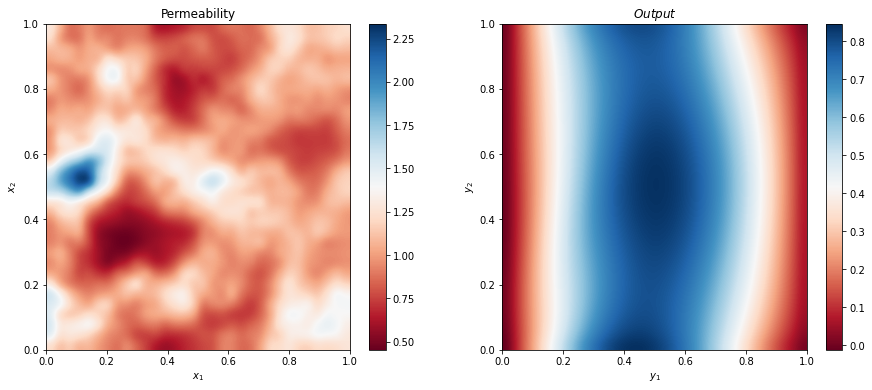

In [ ]:
import matplotlib.pyplot as plt
print(U_test.shape)
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
axs = _axs.flatten()
 
ax1 = axs[0]
ax2 = axs[1]

# Plot 1
cntr1 = ax1.imshow(U_test[0,:,0].reshape(h,h), cmap='RdBu', vmin=U_test[0,:,0].min(), vmax=U_test[0,:,0].max(),
                    extent=[0,1,0,1],
                    interpolation='quadric', origin='lower', aspect='auto')
fig.colorbar(cntr1, ax=ax1)
ax1.set(xlim=(0, 1), ylim=(0, 1))
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax1.set_title("Permeability")

# Plot 2
cntr2 = ax2.imshow(uCNN_super_all_test[0,:,0].reshape(h,h), cmap='RdBu', vmin=uCNN_super_all_test[0,:,0].min(), vmax=uCNN_super_all_test[0,:,0].max(),
      extent=[0,1,0,1],
      interpolation='quadric', origin='lower', aspect='auto')
fig.colorbar(cntr2, ax=ax2)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_xlabel("$y_1$")
ax2.set_ylabel("$y_2$")
ax2.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax2.set_title("$Output$")


In [ ]:
# Save trained model parameters
saveParameters = True
if saveParameters:
    opt_params_flat, _ = ravel_pytree(opt_params)
    np.save("DON_parameters_%dx%d.npy"%(h,h), opt_params_flat)

# END OF THE SECOND TUTORIAL